# Part 0 Importing data

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#https://drive.google.com/file/d/197KT1tgyKkEbsVYR8GCv-6wIdaLPOygc/view?usp=sharing
id = "197KT1tgyKkEbsVYR8GCv-6wIdaLPOygc" #from the drive package
file = drive.CreateFile({'id':id})
file.GetContentFile('imbalancedFraudDF.csv')

fraud_df = pd.read_csv('imbalancedFraudDF.csv')
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [ ]:
#https://drive.google.com/file/d/11X0WLUY0cEihEwpg6a5J2xAf_EI_ZWfR/view?usp=sharing
id2 = "11X0WLUY0cEihEwpg6a5J2xAf_EI_ZWfR"
file = drive.CreateFile({'id':id2})
file.GetContentFile('IpAddress_to_Country.csv')

ipToCountry = pd.read_csv('IpAddress_to_Country.csv')
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# Part 1: Data Exploration

In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138376 entries, 0 to 138375
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         138376 non-null  int64  
 1   signup_time     138376 non-null  object 
 2   purchase_time   138376 non-null  object 
 3   purchase_value  138376 non-null  int64  
 4   device_id       138376 non-null  object 
 5   source          138376 non-null  object 
 6   browser         138376 non-null  object 
 7   sex             138376 non-null  object 
 8   age             138376 non-null  int64  
 9   ip_address      138376 non-null  float64
 10  class           138376 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 11.6+ MB


In [ ]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,138376.000000,138376.000000,138376.000000,1.383760e+05,138376.000000
mean,200149.032245,36.938985,33.125867,2.154381e+09,0.010226
std,115226.781501,18.321091,8.623645,1.250563e+09,0.100605
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100894.750000,22.000000,27.000000,1.085079e+09,0.000000
50%,200000.500000,35.000000,33.000000,2.156471e+09,0.000000
75%,299745.250000,49.000000,39.000000,3.249150e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [ ]:
fraud_df.nunique()

user_id           138376
signup_time       138376
purchase_time     137985
purchase_value       122
device_id         134121
source                 3
browser                5
sex                    2
age                   58
ip_address        137653
class                  2
dtype: int64

<Axes: xlabel='browser', ylabel='count'>

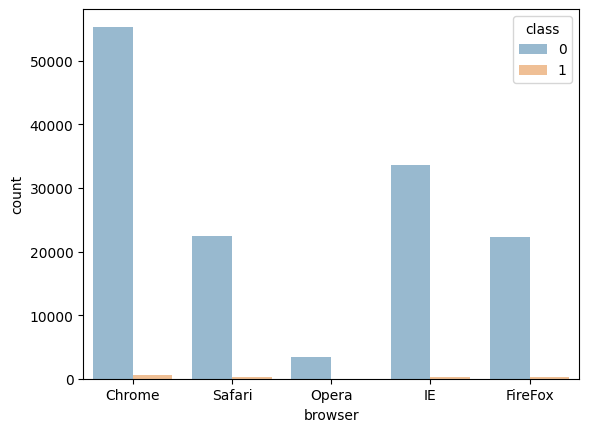

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.countplot(data = fraud_df, x = 'browser', hue = 'class', alpha = 0.5)

<Axes: xlabel='source', ylabel='count'>

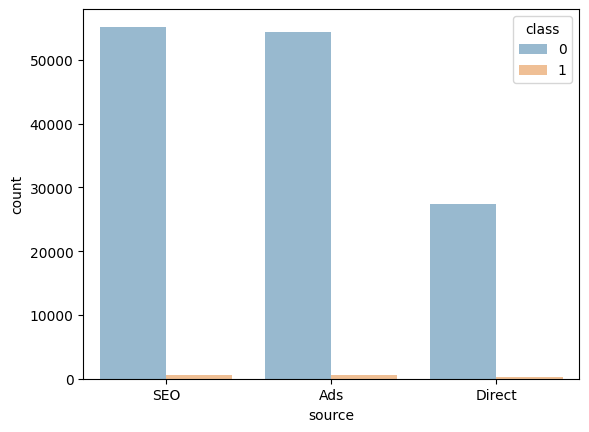

In [ ]:
sns.countplot(data = fraud_df, x = 'source', hue = 'class', alpha = 0.5)

In [ ]:
fraud_df['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

This is a really unbalanced dataset as most of the value are 0. We need to do some feature engineering later

# Part 2 Mapping IP address to country

In [ ]:
countries = []
for i in range(len(fraud_df)):
    ip_address = fraud_df.loc[i, 'ip_address']#number
    #check which interval does ip_address falls into
    #below [] is list of T/F, only when this ip_address falls into the correct internal row does the index generate a True
    #tmp is a df of shape n * 3, where n is 1 if found a match (ip_address falls in range) or 0 if no match
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')

In [ ]:
fraud_df['country'] = countries
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


# Part 3 Feature Engineering

In [ ]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['signup_day'] = fraud_df['signup_time'].dt.dayofyear
fraud_df['signup_seconds_of_day'] = fraud_df['signup_time'].dt.hour * 3600 + fraud_df['signup_time'].dt.minute * 60 + fraud_df['signup_time'].dt.second
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['purchase_day'] = fraud_df['purchase_time'].dt.dayofyear
fraud_df['purchase_seconds_of_day'] = fraud_df['purchase_time'].dt.hour * 3600 + fraud_df['purchase_time'].dt.minute * 60 + fraud_df['purchase_time'].dt.second
fraud_df['interval'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

In [ ]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_day,signup_seconds_of_day,purchase_day,purchase_seconds_of_day,interval
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,55,82549,108,10031,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,158,74390,159,5934,17944.0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,118,76405,124,50090,492085.0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,202,25792,252,67253,4361461.0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,141,21783,190,29114,4240931.0


# Split train test data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
fraud_df = fraud_df.drop(columns = ['signup_time', "purchase_time", 'user_id'])

In [ ]:
X = fraud_df.drop(columns = 'class')
y = fraud_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


# Continuing feature engineering

In [ ]:
X_train = pd.concat([X_train,X_train['browser'].str.get_dummies()], axis = 1)
X_train = pd.concat([X_train,X_train['source'].str.get_dummies()], axis = 1)
X_train['sex'] = X_train['sex'].replace({'M': 1, 'F': 0})
X_train = X_train.drop(columns = ['source', 'browser'])

# the attributes device id, ip address, and country itself are not that useful, we are interested in the common device id, ip address, and country that shares. Intuitively, the more a device is shared, the more suspicious
# the more a ip is shared, the more suspicious, and the less visit from a country the more suspicious


# if device_id abc occurred 100 times in X_train, then replace all abc in device_id col in X_train by 100
device_mapping = X_train['device_id'].value_counts(dropna = False)
X_train['n_device_shared'] = X_train['device_id'].map(device_mapping)
# The map function in pandas is a method of the Series object. It's used to map the values of a Series based on an input correspondence (which can be another Series, dictionary, or a function).
# Essentially, it's a way to transform the values in a Series based on some mapping defined by another object or function.

ip_mapping = X_train['ip_address'].value_counts(dropna = False)
X_train['n_ip_shared'] = X_train['ip_address'].map(ip_mapping)

country_mapping = X_train['country'].value_counts(dropna = False)
X_train['n_country_shared'] = X_train['country'].map(country_mapping)
X_train = X_train.drop(columns = ['device_id','ip_address', 'country'])

In [ ]:
X_train.head()

,purchase_value,sex,age,signup_day,signup_seconds_of_day,purchase_day,purchase_seconds_of_day,interval,Chrome,FireFox,IE,Opera,Safari,Ads,Direct,SEO,n_device_shared,n_ip_shared,n_country_shared
29343,12,1,42,183,67384,224,24648,3499664.0,1,0,0,0,0,1,0,0,1,1,3075
12190,10,1,29,5,78146,84,18585,6766039.0,0,0,0,1,0,1,0,0,1,1,42348
19388,34,1,53,197,81354,265,76669,5870515.0,1,0,0,0,0,0,1,0,1,1,16275
89104,48,1,29,160,30920,185,16538,2145618.0,1,0,0,0,0,1,0,0,1,1,2322
82082,44,1,24,111,71897,193,66156,7079059.0,0,1,0,0,0,1,0,0,1,1,8876


In [ ]:
X_test = pd.concat([X_test,X_test['browser'].str.get_dummies()], axis = 1)
X_test = pd.concat([X_test,X_test['source'].str.get_dummies()], axis = 1)
X_test['sex'] = X_test['sex'].replace({'M': 1, 'F': 0})
X_test = X_test.drop(columns = ['source', 'browser'])

device_test_mapping = X_test['device_id'].value_counts(dropna = False)
X_test['n_device_shared'] = X_test['device_id'].map(device_test_mapping)
# The map function in pandas is a method of the Series object. It's used to map the values of a Series based on an input correspondence (which can be another Series, dictionary, or a function).
# Essentially, it's a way to transform the values in a Series based on some mapping defined by another object or function.
ip_test_mapping = X_test['ip_address'].value_counts(dropna = False)
X_test['n_ip_shared'] = X_test['ip_address'].map(ip_test_mapping)

country_test_mapping = X_test['country'].value_counts(dropna = False)
X_test['n_country_shared'] = X_test['country'].map(country_test_mapping)
X_test = X_test.drop(columns = ['device_id','ip_address', 'country'])

In [ ]:
X_test.head()

,purchase_value,sex,age,signup_day,signup_seconds_of_day,purchase_day,purchase_seconds_of_day,interval,Chrome,FireFox,IE,Opera,Safari,Ads,Direct,SEO,n_device_shared,n_ip_shared,n_country_shared
10224,19,1,34,190,36985,240,28287,4311302.0,0,0,0,0,1,1,0,0,1,1,4016
85132,31,0,41,75,48284,122,67041,4079557.0,1,0,0,0,0,1,0,0,1,1,4016
45717,29,1,30,58,68033,129,38612,6104979.0,1,0,0,0,0,1,0,0,1,1,349
62898,74,0,27,135,42763,195,65354,5206591.0,0,0,1,0,0,0,0,1,1,1,10675
6553,39,0,35,201,59280,205,6223,292543.0,0,0,1,0,0,0,1,0,1,1,1413


In [ ]:
# # normalize (min-max) to [0,1], standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so we do normalize here
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train[['n_device_shared','n_ip_shared', 'n_country_shared']])
X_train[['n_device_shared','n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_device_shared','n_ip_shared', 'n_country_shared']])

X_test[['n_device_shared','n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_device_shared','n_ip_shared', 'n_country_shared']])

In [ ]:
X_train.head()

,purchase_value,sex,age,signup_day,signup_seconds_of_day,purchase_day,purchase_seconds_of_day,interval,Chrome,FireFox,IE,Opera,Safari,Ads,Direct,SEO,n_device_shared,n_ip_shared,n_country_shared
29343,12,1,42,183,67384,224,24648,3499664.0,1,0,0,0,0,1,0,0,0.0,0.0,0.072591
12190,10,1,29,5,78146,84,18585,6766039.0,0,0,0,1,0,1,0,0,0.0,0.0,1.000000
19388,34,1,53,197,81354,265,76669,5870515.0,1,0,0,0,0,0,1,0,0.0,0.0,0.384301
89104,48,1,29,160,30920,185,16538,2145618.0,1,0,0,0,0,1,0,0,0.0,0.0,0.054809
82082,44,1,24,111,71897,193,66156,7079059.0,0,1,0,0,0,1,0,0,0.0,0.0,0.209578


In [ ]:
X_test.head()

,purchase_value,sex,age,signup_day,signup_seconds_of_day,purchase_day,purchase_seconds_of_day,interval,Chrome,FireFox,IE,Opera,Safari,Ads,Direct,SEO,n_device_shared,n_ip_shared,n_country_shared
10224,19,1,34,190,36985,240,28287,4311302.0,0,0,0,0,1,1,0,0,0.0,0.0,0.094812
85132,31,0,41,75,48284,122,67041,4079557.0,1,0,0,0,0,1,0,0,0.0,0.0,0.094812
45717,29,1,30,58,68033,129,38612,6104979.0,1,0,0,0,0,1,0,0,0.0,0.0,0.008218
62898,74,0,27,135,42763,195,65354,5206591.0,0,0,1,0,0,0,0,1,0.0,0.0,0.252060
6553,39,0,35,201,59280,205,6223,292543.0,0,0,1,0,0,0,1,0,0.0,0.0,0.033344


# Part 4 Modeling

### Baseline (Without using SMOTE)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, make_scorer, precision_score, recall_score

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)

In [ ]:
print("confusion matrix is: ")
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cm_matrix)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))  #1.0predicted = classifier_RF.predict(X_test)

print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("f1 score is: ", f1_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

confusion matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     142     145
recall = 0.5052264808362369
precision = 1.0
accuracy_score is: : 0.9948692007515537
f1 score is: : 0.6712962962962962
roc_auc_score is: : 0.7630565972783652


In [ ]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
log_pred = logistic.predict(X_test)
log_prob = logistic.predict_proba(X_test)

print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, log_pred)))
print("%s: %r" % ("f1 score is: ", f1_score(y_test, log_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, log_prob[:, 1])))

cm = confusion_matrix(y_test, log_pred)
cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cm_matrix)


accuracy_score is: : 0.9896300043358867
f1 score is: : 0.0
roc_auc_score is: : 0.7495960572182201
        pred_0  pred_1
true_0   27389       0
true_1     287       0


## Using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
X_train_sm.shape

(219144, 19)

In [ ]:
# check SMOTE result
y_train_sm.value_counts()

0    109572
1    109572
Name: class, dtype: int64

In [ ]:

rf_sm = RandomForestClassifier(random_state = 0, max_depth = 25, n_estimators = 200)
rf_sm.fit(X_train_sm, y_train_sm)
y_sm_pred = rf_sm.predict(X_test)
y_sm_prob = rf_sm.predict_proba(X_test)
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_sm_pred)))
print("%s: %r" % ("f1 score is: ", f1_score(y_test, y_sm_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_sm_prob[:, 1])))

cm = confusion_matrix(y_test, y_sm_pred)
cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cm_matrix)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))

accuracy_score is: : 0.9948330683624801
f1 score is: : 0.6697459584295612
roc_auc_score is: : 0.7686380109108122
        pred_0  pred_1
true_0   27388       1
true_1     142     145
recall = 0.5052264808362369
precision = 0.9931506849315068


In [ ]:
log_sm = LogisticRegression()
log_sm.fit(X_train_sm, y_train_sm)
log_sm_pred = log_sm.predict(X_test)
log_sm_prob = log_sm.predict_proba(X_test)

print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, log_sm_pred)))
print("%s: %r" % ("f1 score is: ", f1_score(y_test, log_sm_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, log_prob[:, 1])))

cm = confusion_matrix(y_test, log_sm_pred)
cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cm_matrix)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))

accuracy_score is: : 0.6881413499060558
f1 score is: : 0.04174530920395248
roc_auc_score is: : 0.7495960572182201
        pred_0  pred_1
true_0   18857    8532
true_1      99     188
recall = 0.6550522648083623
precision = 0.021559633027522937


## Use Grid Search CV to find optimal parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)

}

In [ ]:
def GridSearch(model, parameter, refit, x_train, y_train):
  clf = GridSearchCV(model, parameter, cv = 3, scoring = scorers, refit = refit, return_train_score =True)
  clf.fit(x_train, y_train)

  model_pred = clf.predict(X_test)
  model_prob = clf.predict_proba(X_test)
  print('Best params for {}'.format(refit))
  print(clf.best_estimator_)

  print('Best confusion matrix for the model{}'.format(refit))
  cm = confusion_matrix(y_test, model_pred)
  cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
  print(cm_matrix)
  print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
  print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))

  print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, model_pred)))
  print("%s: %r" % ("f1 score is: ", f1_score(y_test, model_pred)))
  print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, model_prob[:, 1])))
  return clf

## Random Forest with Grid Search

In [ ]:
# parameter_grid = {'max_depth': [15, 20],
#                   'n_estimators': [150, 200]}
# random_forest_sm = RandomForestClassifier(max_features = 'sqrt',random_state = 0)
# clf = GridSearchCV(random_forest_sm, parameter_grid, cv = 3)
# clf.fit(X_train_sm, y_train_sm)
# rf_sm_prediction = clf.predict(X_test)
# rf_sm_proba = clf.predict_proba(X_test)
# cm = confusion_matrix(y_test, rf_sm_prediction)
# cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
# print(cm_matrix)

# print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, rf_sm_prediction)))
# print("%s: %r" % ("f1 score is: ", f1_score(y_test, rf_sm_prediction)))
# print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, rf_sm_proba[:, 1])))

In [ ]:
parameter_grid = {'max_depth': [15, 20],
                  'n_estimators': [150, 200]}
random_forest_sm = RandomForestClassifier(max_features = 'sqrt',random_state = 0)
rf_clf = GridSearch(random_forest_sm, parameter_grid, 'f1_score', X_train_sm, y_train_sm)


Best params for f1_score
RandomForestClassifier(max_depth=30, n_estimators=150, random_state=0)
Best confusion matrix for the modelf1_score
        pred_0  pred_1
true_0   27388       1
true_1     142     145
recall = 0.5052264808362369
precision = 0.9931506849315068
accuracy_score is: : 0.9948330683624801
f1 score is: : 0.6697459584295612
roc_auc_score is: : 0.7658976498487464


In [ ]:
rf_result = pd.DataFrame(rf_clf.cv_results_)
rf_result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_precision_score', 'split1_test_precision_score',
       'split2_test_precision_score', 'mean_test_precision_score',
       'std_test_precision_score', 'rank_test_precision_score',
       'split0_train_precision_score', 'split1_train_precision_score',
       'split2_train_precision_score', 'mean_train_precision_score',
       'std_train_precision_score', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'mean_test_recall_score', 'std_test_recall_score',
       'rank_test_recall_score', 'split0_train_recall_score',
       'split1_train_recall_score', 'split2_train_recall_score',
       'mean_train_recall_score', 'std_train_recall_score',
       'split0_test_f1_score', 'split1_test_f1_score', 'split2_test_f1_score',
       'mean_test_f1_score', 'std_test_f1_score', 'rank_test_f1_score',
  

In [ ]:
rf_result[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score',
           'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score']]

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score
0,0.999972,0.987177,0.993526,1.0,0.990855,0.995405
1,0.999982,0.986867,0.993373,1.0,0.990454,0.995203
2,0.999954,0.994834,0.997378,1.0,0.999932,0.999966
3,0.999936,0.994935,0.997419,1.0,1.000000,1.000000


In [ ]:
best_rf_sm = rf_clf.best_estimator_
best_rf_sm

RandomForestClassifier(max_depth=30, n_estimators=150, random_state=0)

Random Forest refit by recall score

In [ ]:
parameter_grid = {'max_depth': [20, 40],
                  'n_estimators': [50, 150]}
random_forest_sm = RandomForestClassifier(max_features = 'sqrt',random_state = 0)
rf_clf_recall = GridSearch(random_forest_sm, parameter_grid, 'recall_score', X_train_sm, y_train_sm)

Best params for recall_score
RandomForestClassifier(max_depth=40, n_estimators=150, random_state=0)
Best confusion matrix for the modelrecall_score
        pred_0  pred_1
true_0   27387       2
true_1     142     145
recall = 0.5052264808362369
precision = 0.9863945578231292
accuracy_score is: : 0.9947969359734066
f1 score is: : 0.6682027649769584
roc_auc_score is: : 0.7669659466789166


In [ ]:
rf_recall_result = pd.DataFrame(rf_clf_recall.cv_results_)
rf_recall_result[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score',
           'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score']]

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score
0,0.999973,0.994232,0.997084,1.0,0.999530,0.999765
1,0.999936,0.994378,0.997139,1.0,0.999694,0.999847
2,0.999945,0.994789,0.997350,1.0,0.999927,0.999963
3,0.999936,0.994907,0.997405,1.0,1.000000,1.000000


In [ ]:
best_rf_recall = rf_clf_recall.best_estimator_
best_pred_recall = best_rf_recall.predict(X_test)
best_prob_recall = best_rf_recall.predict_proba(X_test)

## Logistic Regression with Grid Search

In [ ]:
parameter = {"penalty": ['l1', 'l2'], "C": [0.5, 1.0, 2.0, 2.5], 'max_iter': [100, 200]}
logistic_sm = LogisticRegression(random_state = 0)
log_clf = GridSearch(logistic_sm, parameter, 'f1_score', X_train_sm, y_train_sm)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best params for f1_score
LogisticRegression(C=0.5, random_state=0)
Best confusion matrix for the modelf1_score
        pred_0  pred_1
true_0   18857    8532
true_1      99     188
recall = 0.6550522648083623
precision = 0.021559633027522937
accuracy_score is: : 0.6881413499060558
f1 score is: : 0.04174530920395248
roc_auc_score is: : 0.6876833103856771


In [ ]:
log_result = pd.DataFrame(log_clf.cv_results_)
log_result[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score',
           'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score']]

# Fraud's characteristic

In [ ]:
pd.DataFrame(best_rf_sm.feature_importances_, index  = X_train_sm.columns, columns = ['importance']).sort_values(by = ['importance'], ascending = False)

In [ ]:
training = pd.concat([X_train_sm, y_train_sm], axis = 1)

In [ ]:
training.groupby(by = 'class').mean()[['interval']]

,interval
class,
0,5.198349e+06
1,2.528543e+06


If the purchase interval after sign up the shorter, the more likely that the customer is a fraud.

In [ ]:
training.groupby(by = 'class').mean()[['n_device_shared']]

,n_device_shared
class,
0,0.008898
1,0.202640


If the orders are shared by more devices, the more likely the fraud is.

In [ ]:
training.groupby(by = 'class').mean()[['n_ip_shared']]

,n_ip_shared
class,
0,0.000809
1,0.170639


If the orders are shared by multiple same addresses, the more likely the fraud is.

In [ ]:
training.groupby(by = 'class').mean()[['purchase_seconds_of_day']]

,purchase_seconds_of_day
class,
0,43262.892546
1,42612.121263


In [ ]:
training.groupby(by = 'class').mean()[['n_country_shared']]

,n_country_shared
class,
0,0.473953
1,0.462142


## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
y_train.value_counts()

0    109572
1      1128
Name: class, dtype: int64

In [ ]:
isolate = IsolationForest(n_estimators = 100, max_samples = 180, random_state = 0)
isolate.fit(X_train)
isolate_pred = isolate.predict(X_test)
isolate_pred = [0 if i == -1 else 1 for i in isolate_pred]
cm = confusion_matrix(y_test, isolate_pred)
cm_matrix = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cm_matrix)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))

print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, isolate_pred)))
print("%s: %r" % ("f1 score is: ", f1_score(y_test, isolate_pred)))

        pred_0  pred_1
true_0   17287   10102
true_1     246      41
recall = 0.14285714285714285
precision = 0.00404219658878044
accuracy_score is: : 0.6261020378667438
f1 score is: : 0.007861936720997125


# Part 5 Model Application

In [ ]:
rank = 1 * (best_prob_recall[:,1]).astype(int)
unique, count = np.unique(rank, return_counts=True)
print(np.asarray((unique, count)).T)

[[    0 27645]
 [    1    31]]
